# Sentiment Prediction on Movie Reviews

**Group: ID49**
**Team Members:** Lim Jing Rui, Nicole Chong Jing Xuan, Shi ShuangQi, Tee Yue Ning

Our project aims to harness the power of machine learning models to extract meaningful insights from movie reviews, contributing to a better understanding of audience sentiment and its implications for the film industry. Through our exploration, we strive to provide actionable insights that empower stakeholders to make informed decisions and enhance the overall cinematic experience for audiences.

## Instructions

If you wish to run the code, please follow these instructions:

Download the `glove.6B.zip` GloVe embeddings file from this website: https://nlp.stanford.edu/projects/glove/ .
We will be using the **200-dimensional** file for this project.

**Google Colab**
- Ensure that the `imdb_top60.csv` and `glove.6B.200d.txt` files are uploaded onto your Google Drive, in the same directory.
- Run the code as per usual.

**Deepnote**
- Upload both `imdb_top60.csv` and `glove.6B.200d.txt` files to the workspace on the left sidebar.
- Change the `read_csv()` statement to this: `imdb = pd.read_csv('/work/imdb_top60.csv')`.
- Change the file path in the `load_emb_matrix()` function to `'/work/imdb_top60.csv'` as well.

**Local Computer**
- Ensure that the `imdb_top60.csv` and `glove.6B.200d.txt` files are uploaded onto your computer, in the same directory.
- Change the import statement to import from the specific file path when loading the data and in the `load_emb_matrix()` function.

## Data Collection: Web Scraping from IMDb

Our group decided to scrape the individual reviews from the IMDb website, given its rich source of reviews as one of the largest and most popular online databases for movies, TV shows and related content. IMDb also has a diverse user base, providing a broad range of perspectives and opinions on movies. We collectively thought that it would be the most intuitive to scrape reviews from English language movies since there is a higher chance that the reviews will be in English as well. This will aid us in thoroughly understanding the data for the downstream steps and predictions.

For this project, we scraped 60 English movies sorted by popularity, considering the resource constraints and computational time we may be limited to. In total, this amounted to 64,052 reviews. Through the web scraping process, we noticed that some movies listed do not have any user reviews, but rather only have critic reviews and external reviews. Since our main target group is movie watchers, we then proceeded to filter for movies with a star rating from 1.0 to 10.0. In this way, the movies present in our final data frame all have user reviews, increasing the number of training data points for the model.

From each review, we extracted:
- Movie title
- Date of review
- Username of the individual who posted the review
- Rating (in terms of number of stars)
- Headline of the review
- Full text review


Each represents a variable in the dataframe.

In [ ]:
# install relevant libraries
!pip install selenium
!pip install scrapy
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from scrapy.selector import Selector
import time
import numpy as np
import csv
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.8.0
    Not uninstalling typing-extensions at /shared-libs/python3.11/py/lib/python3.11/site-packages, outside environment /root/venv
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Not uninstalling attrs at /shared-libs/python3.11/py-core/lib/python3.11/site-packages, outside environment /root/venv
    Can't uninstall 'attrs'. No files were found to uninstall.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip



In [ ]:
# Create driver
driver = webdriver.Chrome()

# Get url of english movies
driver.get("https://www.imdb.com/search/title/?title_type=feature&user_rating=1,10&languages=en")

for i in range(1):
    # Dind all hyperlinks to movie description (50 per time)
    button_exists = True # 50 more button exists
    delay = 10 # Delay time 10 seconds
    while button_exists == True:
        try:
            more_button = WebDriverWait(driver, delay).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="__next"]/main/div[2]/div[3]/section/section/div/section/section/div[2]/div/section/div[2]/div[2]/div[2]/div/span/button')))
            more_button.click()

        except:
            button_exists = False

movies = driver.find_elements("xpath", '//*[@id="__next"]/main/div[2]/div[3]/section/section/div/section/section/div[2]/div/section/div[2]/div[2]/ul/li/div/div/div/div[1]/div[2]/div[1]/a')

# Get all movie description links
all_movie_desc_links = []
for movie in movies:
    movie_desc_link = movie.get_attribute("href")
    all_movie_desc_links.append(""+ movie_desc_link + "")
        

# Get all review links
all_review_links = []
for link in all_movie_desc_links:
    driver.get(link)
    reviews_link = driver.find_elements("xpath", '//*[@id="__next"]/main/div/section[1]/section/div[3]/section/section/div[3]/div[2]/div[2]/ul/li[1]/a')
    for link in reviews_link:
        reviews_webpage = link.get_attribute("href")
        all_review_links.append("" + reviews_webpage + "")

# Lists to store each element
all_movie_titles = []
rating_list = []
review_date_list = []
review_title_list = []
author_list = []
review_list = []
error_url_list = []
error_msg_list= []

for link in all_review_links:
    driver.get(link)
    got_button = True 
    wait = 60 
    while got_button == True:
        try:
            load_more_button = WebDriverWait(driver, wait).until(EC.element_to_be_clickable((By.XPATH, '//button[@class="ipl-load-more__button"]')))
            load_more_button.click()
        except:
            got_button = False # Loaded all reviews alr so no more button

    # Gives all parts that match the xpath (ie. all reviews for the same movie)
    movie_reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

    movie_title = driver.find_elements("xpath", '//*[@id="main"]/section/div[1]/div/div/h3') # get title of movie


    final_title = '' # Initialise so it is accessible outside the for loop below
    for title in movie_title:
        final_title = title.text

    for review in movie_reviews:
        try:
            selector = Selector(text = review.get_attribute('innerHTML'))

            try:
                rating = selector.css('.rating-other-user-rating span::text').extract_first() 
                
            except:
                rating = np.NaN

            try:
                text_review_nodes = selector.css('.text.show-more__control::text').getall() # Captures paragraphs separated by <br> in html
                text_review = ' '.join(text_review_nodes)
            except:
                text_review = np.NaN

            try:
                date = selector.css('.review-date::text').extract_first()
            except:
                date = np.NaN

            try:
                title = selector.css('a.title::text').extract_first()
            except:
                title = np.NaN

            try:
                author = selector.css('.display-name-link a::text').extract_first()
            except:
                author = np.NaN

            all_movie_titles.append(final_title)
            rating_list.append(rating)
            review_date_list.append(date)
            review_title_list.append(title)
            author_list.append(author)
            review_list.append(text_review)
            
        except Exception as e:
            error_url_list.append(link)
            error_msg_list.append(e)

reviews_df = pd.DataFrame({
    'movie':all_movie_titles,
    'review_date':review_date_list,
    'author':author_list,
    'rating':rating_list,
    'review_title':review_title_list,
    'full_review':review_list
        })
    
driver.close()

# Export as csv
csv_path = '/Users/nicolechong/Downloads/Y3S2/CS3244/ML_project/imdb_scraping/imdb_all_reviews.csv'
reviews_df.to_csv(csv_path, index=True)

## Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import re
import matplotlib.pyplot as plt 
imdb = pd.read_csv('/content/drive/My_Drive/imdb_top60.csv')

In [ ]:
imdb.head(10)

,Unnamed: 0,movie,review_date,author,rating,review_title,full_review
0,0,Dune: Part Two (2024),26 February 2024,AfricanBro,9.0,Long live the fighters\n,Phenomenal stuff. I'll probably calm down tomo...
1,1,Dune: Part Two (2024),26 February 2024,her5066,10.0,This is what Hollywood needs!\n,This is what Hollywood needs. A great story wi...
2,2,Dune: Part Two (2024),28 February 2024,and_mikkelsen,10.0,Ladies and gentleman.. the PEAK of filmmaking...,This is the kind of movie that is impossible t...
3,3,Dune: Part Two (2024),4 March 2024,HalBanksy,10.0,Arrakis is Real. Believe Me I've Seen It.\n,A monumental piece of cinema. And combined wit...
4,4,Dune: Part Two (2024),26 February 2024,Dvir971,10.0,The Sci-Fi/Fantasy Epic of our Generation\n,Had the pleasure to watch this film in an earl...
5,5,Dune: Part Two (2024),26 February 2024,Ellimof,10.0,WOW! I need Dune Messiah now.\n,"If you liked or loved the first one, the same ..."
6,6,Dune: Part Two (2024),1 March 2024,poseyfan,10.0,Paul Atreides is handled masterfully\n,"""Dune"" has been successfully put to the big sc..."
7,7,Dune: Part Two (2024),26 February 2024,awessel-58117,10.0,"A masterpiece, a pillar of sci-fi/fantasy\n",This was a perfect sequel to Denis' part one. ...
8,8,Dune: Part Two (2024),28 February 2024,HabibieHakim123,10.0,"One Of The Greatest Sequel Ever Made, Dune: P...","In the quiet embrace of ink and page, a story ..."
9,9,Dune: Part Two (2024),29 February 2024,Sleepin_Dragon,10.0,"A movie of epic proportions, everything I'd h...",Paul has to prove himself to both Chani and Th...


In [ ]:
imdb.shape

(64052, 7)

### Data cleaning

Basic data cleaning protocol was conducted, including:
- Checking each column for NA/NaN values
- Removing duplicate rows
- Removing unnamed index column
- Changing variables into appropriate types
- Extract the year from the movie column and put it in another `year_released` column

In [ ]:
# check each column for NaN values 
print(imdb.isnull().sum()) # 'rating' and 'full_review' columns have NA values

# Drop rows where 'rating' column has NaN values
cleaned_df = imdb.dropna(subset=['rating'])

# Utilise information from review title in full_review for those with NA values in full_review column
cleaned_df['full_review'].fillna(cleaned_df['review_title'], inplace = True)

print(cleaned_df.isnull().sum())

# Remove any duplicate rows 
cleaned_df.drop_duplicates(inplace = True)
print(len(cleaned_df))

# Remove unnamed column 
clean_df = cleaned_df.drop(cleaned_df.columns[0], axis=1)

# Rating is in a float format. change rating to integer
clean_df['rating'] = clean_df['rating'].astype(int)

# Date is in string. convert to date format
from datetime import datetime
clean_df['review_date'] = pd.to_datetime(clean_df['review_date'], format = '%d %B %Y').dt.date

# Extract year of movie that is also under 'movie' column, and put in another created year_released column
clean_df['year_released'] = clean_df['movie'].apply(lambda x: x[-5:-1])

Unnamed: 0         0
movie              0
review_date        0
author             0
rating          1999
review_title       0
full_review       12
dtype: int64
Unnamed: 0      0
movie           0
review_date     0
author          0
rating          0
review_title    0
full_review     0
dtype: int64
/tmp/ipykernel_77/1165186422.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['full_review'].fillna(cleaned_df['review_title'], inplace = True)
62053
/tmp/ipykernel_77/1165186422.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop_duplicates(inplace = True)


We removed the string ```' (year)'``` from each entry in the ```movie``` column to leave only the actual movie title in that column. 

In [ ]:
# define function to remove last 7 characters for each movie 
def remove_year(value):
    return value[:-7]
    
# Apply function to movie column
clean_df['movie'] = clean_df['movie'].apply(remove_year)

In [ ]:
print(clean_df.isnull().sum())

movie            0
review_date      0
author           0
rating           0
review_title     0
full_review      0
year_released    0
dtype: int64


For sentiment analysis, it is essential remove unnecessary elements that may affect the model training and deployment, as well as other downstream processes. 
- Punctuation, numbers and stopwords can introduce noise into the data. Removing them enables the model to focus on the words that are more relevant for determining sentiment. Just like how data normalisation is conducted on numerical variables, removing punctuation and numbers is a form of text normalisation as well.

- Lowercasing the text reviews can improve matching and tokenisation processes by ensuring that words with the same meaning but different cases are treated as equivalent. Consequently, bias can be decreased and the model will have a higher accuracy.

- Stripping whitespaces removes unnecessary spaces at the beginning and end of the text, which can sometimes be introduced during data collection or preprocessing. This helps to remove redundant information that does not contribute to the analysis.

- Removing links and stopwords that will not be helpful during the model training process. We utilised the default NLTK stopwords to remove common words such as "the", "is", "at" as they typically do not have high significance in the context of natural language understanding.

In [ ]:
# import libraries
!pip3 install contractions
import string
import nltk
from string import digits
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("stopwords")

# Create another copy of full_review column
clean_df['final_clean_reviews'] = clean_df['full_review']

# Remove numbers from reviews
clean_df['final_clean_reviews'] = clean_df['final_clean_reviews'].str.replace('\d+', '', regex = True)

# Remove punctuation from reviews
punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for char in punctuation:
    clean_df['final_clean_reviews'] = clean_df['final_clean_reviews'].str.replace(char, '')

# Convert to lower-case
clean_df['final_clean_reviews'] = clean_df['final_clean_reviews'].str.lower()

# Strip whitespaces between paragraphs
clean_df['final_clean_reviews'] = clean_df['final_clean_reviews'].str.strip()

# Remove links from reviews
clean_df['final_clean_reviews'] = clean_df['final_clean_reviews'].replace(r'http\S+', '',regex=True).replace(r'www\S+','',regex=True)

# Remove stopwords from reviews
stop_words = stopwords.words("english")
clean_df['final_clean_reviews'] = clean_df['final_clean_reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Remove contractions
import contractions
for review in clean_df['final_clean_reviews']:
    contractions.fix(review)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 30.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Tokenising

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

clean_df['tokens'] = clean_df['final_clean_reviews'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Removing words with accented letters, emojis and Chinese words

Upon scrutinising the individual reviews, we noticed that there were accented letters such as **é**, emojis and even chinese words. Thus, we defined a function to remove these anomalies so that the reviews will only consist of alphabets from 'a' to 'z'.

In [ ]:
import unicodedata
alphabets = set(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

def remove_non_alphabets(word, alphabets):
    cleaned_var = ''
    for character in word:
        if character.isalpha() and character in alphabets:
            cleaned_var += character
        elif unicodedata.category(character)[0] in ('S', 'L'):
            continue
        else:
            cleaned_var += ''
    return cleaned_var

cleaned_tokens = []
for inner_list in clean_df['tokens']:
    cleaned_list = [remove_non_alphabets(word, alphabets) for word in inner_list]
    cleaned_tokens.append(cleaned_list)

clean_df['tokens'] = cleaned_tokens
clean_df = pd.DataFrame(clean_df)

### Creating Label Column

Since we scraped the data from the IMDB website itself, the data is unlabelled and does not have a class assigned. Thus, we decided on using the `rating` column to determine the label in order to train the model since it would be the most useful and intuitive column to use. When a user gives a high rating (eg. 8 out of 10 stars), the class assigned will most likely be positive.

The `label` column will act as our target variable for prediction of sentiment class.

/tmp/ipykernel_78/24215124.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = percentage.index, y = percentage, palette = colours)


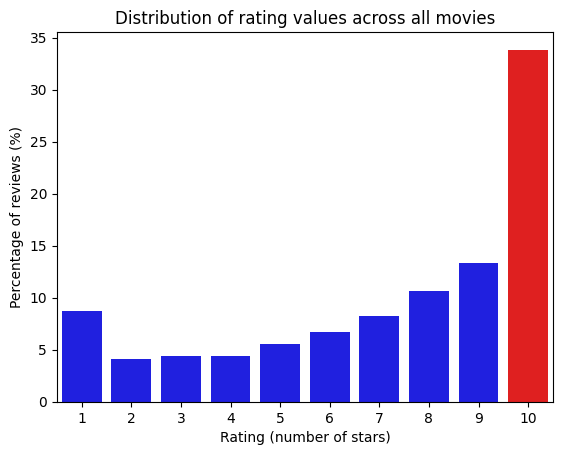

In [ ]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Checking distribution/density of ratings values in terms of percentage to decide threshold values and categories
percentage = clean_df['rating'].value_counts(normalize = True) * 100 
colours = ['blue'] * len(percentage.index)
colours[9] = 'red'
sns.barplot(x = percentage.index, y = percentage, palette = colours)
plt.xlabel('Rating (number of stars)')
plt.ylabel('Percentage of reviews (%)')
plt.title('Distribution of rating values across all movies')
plt.show()


The above bar graph is useful in helping us determine the threshold for the range of ratings to be converted into labels. Looking at the distribution of rating values across all movies, the bar graph is **left-skewed**,where most of the ratings are towards the range of 9 or 10 stars. In fact, close to 35% of the reviews alone have a strong rating of 10 stars.

Most sentiment analysis projects usually have binary labels, either positive or negative. Here, we attempt to include another category "Neutral". Not all reviews express clear positive or negative sentiment. Some reviews may be neutral, thus this category aims to capture this middle ground, providing a more accurate representation of sentiment in the data. As such, we decided to proceed with a **multi-class classification system** as follows:

| Range of stars | Corresponding Class | Corresponding Label |
|:---------------:|:------------------:|:-------------------:|
| 1 - 3          | Negative            | -1                 |
| 4 - 7          | Neutral             | 0                   |
| 8 - 10         | Positive            | 1                   |



In [ ]:
bins = [0, 4, 8,11]  
labels = [-1,0,1]  # Corresponding labels

# Create new categorical label column (ie. target column)
clean_df['label'] = pd.cut(clean_df['rating'], bins=bins, labels=labels, right=False)

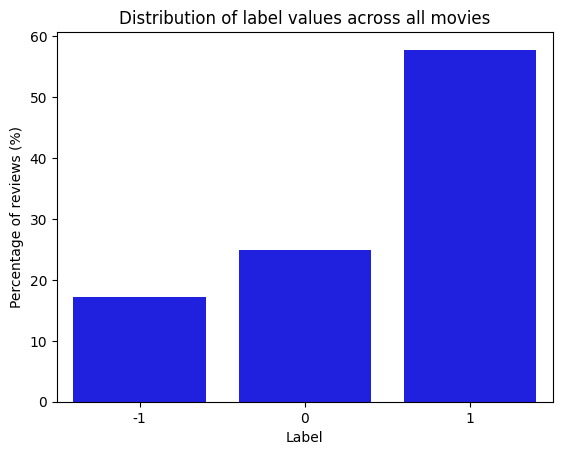

In [ ]:
# Checking distribution/density of label values in terms of percentage
percentage = clean_df['label'].value_counts(normalize = True) * 100 
sns.barplot(x = percentage.index, y = percentage, color = 'blue')
plt.xlabel('Label')
plt.ylabel('Percentage of reviews (%)')
plt.title('Distribution of label values across all movies')
plt.show()

The distribution remains uneven after combining. We will counter this by using **oversampled** data as input into the models. 

### Identifying Common Words

Common words are often considered important features for sentiment analysis. By identifying and keeping only these words, we can create a feature set that captures the most relevant information for classification. At the same time, common words can also convey little to no sentiment information and are considered noise.

From the wordcloud below, we see that 'movie' and 'film' are 2 of the most frequent words used in the reviews across the dataset, yet they may not be informative for the model and in turn can reduce the efficiency of machine learning or deep learning algorithms.

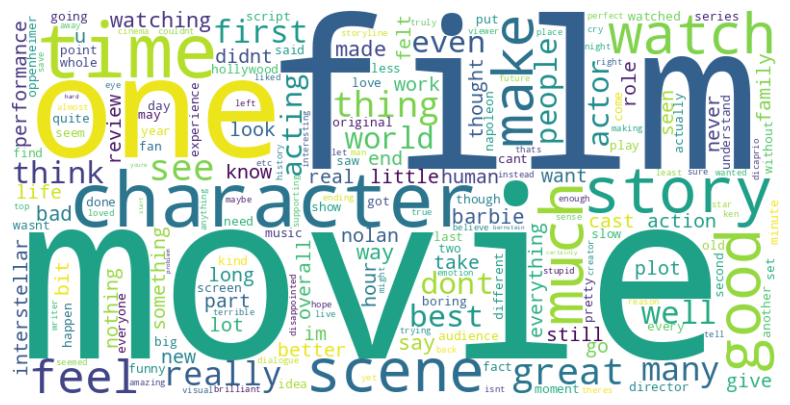

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# Determine the number of samples per class
samples_per_class = 50  # Adjust as needed

# Perform stratified sampling
sampled_tokens = []
for label in clean_df['label'].unique():
    label_subset = clean_df[clean_df['label'] == label]
    sampled_obs = random.sample(label_subset['tokens'].tolist(), samples_per_class)
    sampled_tokens.extend([token for sublist in sampled_obs for token in sublist])

# Join the sampled tokens
sample_text = ' '.join(sampled_tokens)

# Create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


We can see that words relating to the theme of the dataset make up the most frequent words across all labels. We will hence be removing them since these words do not affect the sentiment class of the reviews.


In [ ]:
common_words = ['film', 'movie','movies','character', 'story','time', 'one', 'scene']
# Remove common words from tokens
clean_df['tokens'] = clean_df['tokens'].apply(lambda tokens: [token for token in tokens if token not in common_words])

We decided to keep words that occur at least thrice across all the reviews in the dataset. The choice of number reflects our consideration to effectively filter out words that are less likely to be associated with a sentiment class, but also minimise the risk of removing crucial information.

In [ ]:
token_counts = {}
for tokens in clean_df['tokens']:
  for token in tokens: 
    token_counts[token] = token_counts.get(token,0) + 1

print("Number of words before extraction: ", len(token_counts))
# Sort token_counts by counts in decreasing order
sorted_token_counts = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)

# Filter tokens with counts > 2
filtered_token_counts = [(token, count) for token, count in sorted_token_counts if count > 2]

# Convert back to a dictionary
filtered_token_counts_dict = dict(filtered_token_counts)

# Printing or using filtered_token_counts_dict
print("Number of words after extraction: ", len(filtered_token_counts_dict))

clean_df['final_tokens'] = clean_df['tokens'].apply(lambda tokens: [token for token in tokens if token in filtered_token_counts_dict])

Number of words before extraction:  102348
Number of words after extraction:  37218


### Stemming

In [ ]:
# Perform stemming using PorterStemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return[stemmer.stem(word) for word in tokens]

clean_df['stemmed_tokens'] = clean_df['final_tokens'].apply(stem_tokens)

In [ ]:
clean_df[['final_tokens', 'stemmed_tokens']].head(20)

,final_tokens,stemmed_tokens
0,"[phenomenal, stuff, ill, probably, calm, tomor...","[phenomen, stuff, ill, probabl, calm, tomorrow..."
1,"[hollywood, needs, great, great, directorprodu...","[hollywood, need, great, great, directorproduc..."
2,"[kind, impossible, justice, talking, kind, exp...","[kind, imposs, justic, talk, kind, experi, nev..."
3,"[monumental, piece, cinema, combined, part, gr...","[monument, piec, cinema, combin, part, greates..."
4,"[pleasure, watch, early, screening, completely...","[pleasur, watch, earli, screen, complet, blown..."
5,"[liked, loved, first, apply, personally, loved...","[like, love, first, appli, person, love, even,..."
6,"[dune, successfully, put, big, screen, good, a...","[dune, success, put, big, screen, good, adapt,..."
7,"[perfect, sequel, denis, part, accomplished, m...","[perfect, sequel, deni, part, accomplish, main..."
8,"[quiet, embrace, ink, page, unfolded, timeless...","[quiet, embrac, ink, page, unfold, timeless, s..."
9,"[paul, prove, chani, fremen, dreams, become, v...","[paul, prove, chani, fremen, dream, becom, viv..."


Looking at the `final_tokens` VS `stemmed_tokens`, words that carry a sentiment are actually butchered into a non-English word. For example, **'incredible' becomes 'incredi'** and **'beautiful' becomes 'beauti'**. Both words imply a positive sentiment but due to stemming, the model may not be able to infer this. This was a sufficient reason for us to not proceed with stemming.

### Join Tokens Back

In [ ]:
clean_df['joined_reviews'] = clean_df['final_tokens'].apply(lambda x: ' '.join(x))

# Replace final_clean_reviews with joined_reviews, then delete joined_reviews
clean_df['final_clean_reviews'] = clean_df['joined_reviews']
clean_df.drop(columns = ['joined_reviews'], inplace = True)

In [ ]:
# Alphabet count dictionary
from collections import Counter
import nltk

word_counts = Counter()
for tokens in clean_df['final_clean_reviews']:
    for token in tokens:
        word_counts.update(token)

vocab = dict(word_counts)
print(vocab)

{'p': 857419, 'h': 898871, 'e': 4150632, 'n': 2357429, 'o': 2072556, 'm': 929152, 'a': 2466491, 'l': 1857754, ' ': 5242260, 's': 2264182, 't': 2429268, 'u': 901048, 'f': 529146, 'i': 2415737, 'r': 2142458, 'b': 463541, 'y': 685675, 'c': 1270684, 'w': 521303, 'g': 977295, 'k': 372215, 'z': 37223, 'd': 1240308, 'x': 94235, 'v': 430162, 'j': 56931, 'q': 40638}


Looking at the individual characters across all reviews, we see that there exists only alphabets from a to z, reflecting clean data.

## Exploratory Data Analysis

In [ ]:
clean_df.head()

,movie,review_date,author,rating,review_title,full_review,year_released,final_clean_reviews,tokens,label,final_tokens,stemmed_tokens
0,Dune: P,2024-02-26,AfricanBro,9,Long live the fighters\n,Phenomenal stuff. I'll probably calm down tomo...,2024,phenomenal stuff ill probably calm tomorrow ri...,"[phenomenal, stuff, ill, probably, calm, tomor...",1,"[phenomenal, stuff, ill, probably, calm, tomor...","[phenomen, stuff, ill, probabl, calm, tomorrow..."
1,Dune: P,2024-02-26,her5066,10,This is what Hollywood needs!\n,This is what Hollywood needs. A great story wi...,2024,hollywood needs great great directorproducer b...,"[hollywood, needs, great, great, directorprodu...",1,"[hollywood, needs, great, great, directorprodu...","[hollywood, need, great, great, directorproduc..."
2,Dune: P,2024-02-28,and_mikkelsen,10,Ladies and gentleman.. the PEAK of filmmaking...,This is the kind of movie that is impossible t...,2024,kind impossible justice talking kind experienc...,"[kind, impossible, justice, talking, kind, exp...",1,"[kind, impossible, justice, talking, kind, exp...","[kind, imposs, justic, talk, kind, experi, nev..."
3,Dune: P,2024-03-04,HalBanksy,10,Arrakis is Real. Believe Me I've Seen It.\n,A monumental piece of cinema. And combined wit...,2024,monumental piece cinema combined part greatest...,"[monumental, piece, cinema, combined, part, gr...",1,"[monumental, piece, cinema, combined, part, gr...","[monument, piec, cinema, combin, part, greates..."
4,Dune: P,2024-02-26,Dvir971,10,The Sci-Fi/Fantasy Epic of our Generation\n,Had the pleasure to watch this film in an earl...,2024,pleasure watch early screening completely blow...,"[pleasure, watch, early, screening, completely...",1,"[pleasure, watch, early, screening, completely...","[pleasur, watch, earli, screen, complet, blown..."


### Text Length Distribution by Sentiment Class

/tmp/ipykernel_78/998243637.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  text_lengths_grouped = clean_df.groupby('label')['final_tokens'].apply(lambda x: x.apply(len).mean())


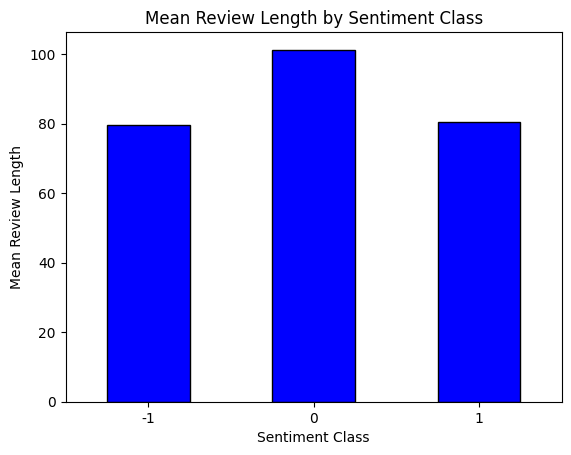

In [ ]:
# Text length distribution analysis by label 
text_lengths_grouped = clean_df.groupby('label')['final_tokens'].apply(lambda x: x.apply(len).mean())
text_lengths_grouped

# Plotting the text length distribution grouped by sentiment class
text_lengths_grouped.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Mean Review Length by Sentiment Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Mean Review Length')
plt.xticks(rotation=0)
plt.show()

As observed in the bar chart above, the **average review length** is approximately **90 words across all 3 classes**. Sentiment class 0, which corresponds to **neutral** sentiments of movie by users, has the highest mean review length of approximately **110 words**.

### Word Cloud by Sentiment Class


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
/tmp/ipykernel_77/3218320184.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_tokens = clean_df.groupby('label')['final_tokens'].apply(lambda x: ' '.join([' '.join(words) for words in x]))


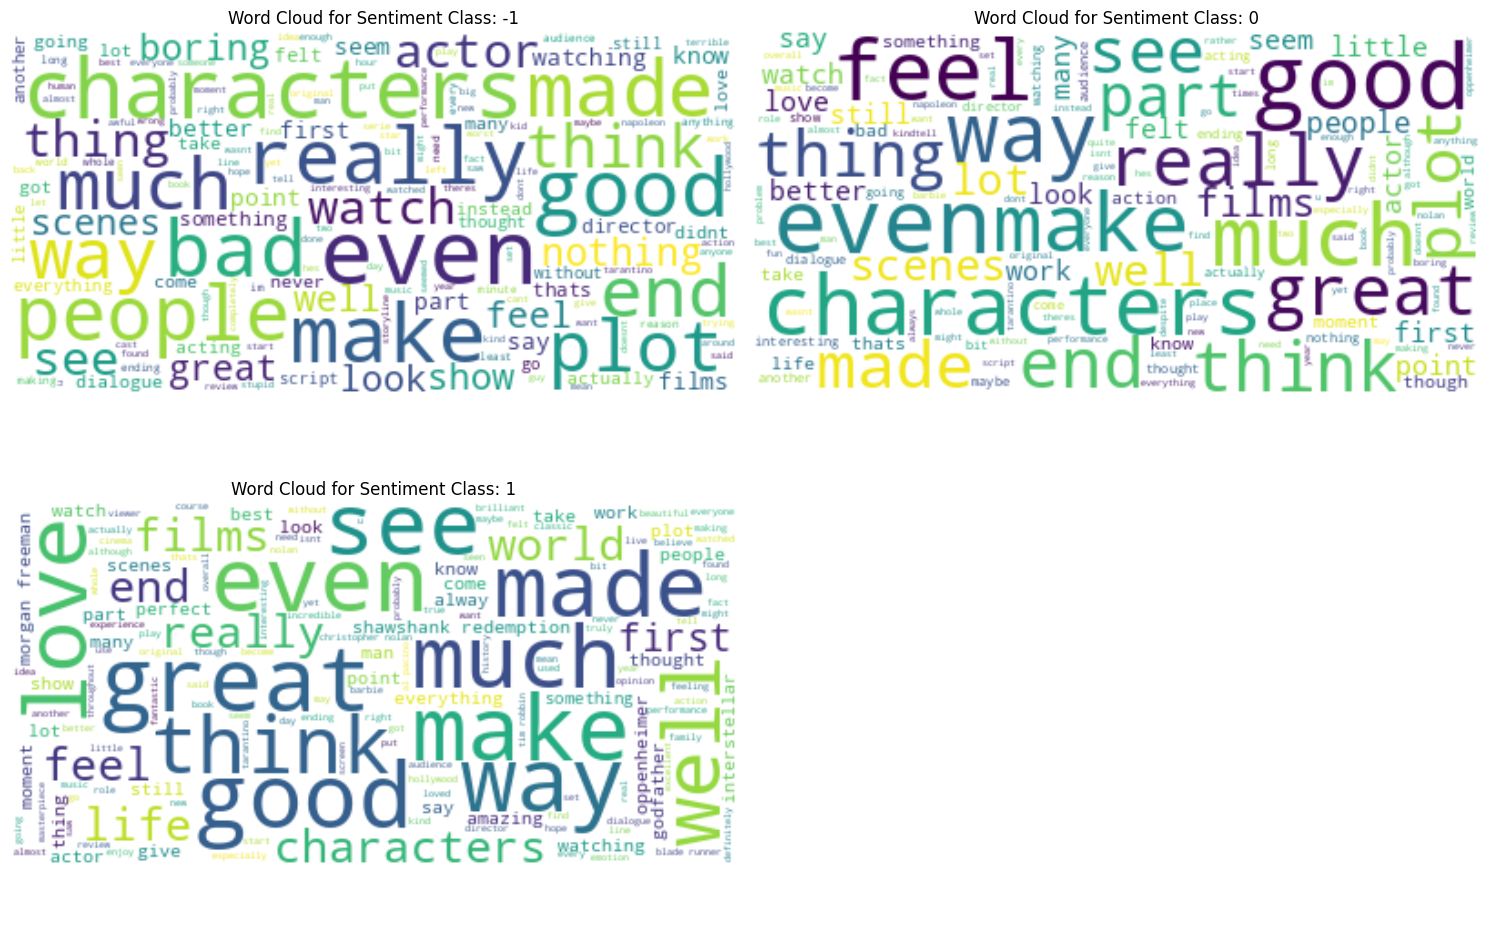

In [ ]:
# Group the tokenized reviews by sentiment class
grouped_tokens = clean_df.groupby('label')['final_tokens'].apply(lambda x: ' '.join([' '.join(words) for words in x]))

# Create a new figure with 3x2 grid layout
fig, axes = plt.subplots(2,2, figsize=(15, 10))

# Flatten the axes array to iterate over subplots
axes = axes.flatten()

# Generate word clouds for each sentiment class and plot them on subplots
for i, (sentiment_class, tokens) in enumerate(grouped_tokens.items()):
    # Create WordCloud object
    wordcloud = WordCloud(width=400, height=200, background_color='white', max_font_size=50).generate(tokens)
    
    # Plot the word cloud on the current subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud for Sentiment Class: {sentiment_class}')
    axes[i].axis('off')

# Hide any empty subplots (if any)
for j in range(len(grouped_tokens), len(axes)):
    axes[j].axis('off')

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()

This word cloud allows us to have a quick overview of most frequently occurring words for each sentiment class. From the output above, we can see how sentiment class -1 ("Negative") has more negative words like "boring" and "bad", while "love" and "great" appear in the "Positive" class. However, "good" and "like" appear frequently in **all** sentiment classes. Regardless, there seems to be greater frequency of positive words in the "Positive" sentiment class. 

### Word Frequency Dictionary by Sentiment Class

To visualise the top words in the reviews classified by sentiment class, we plotted a bar chart of the 20 most frequent words used in each class.

In [ ]:
import operator
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

# Word count freq dictionary for each sentiment class
word_freq_by_label = {}
for label in clean_df['label'].unique():
    filtered_df = clean_df[clean_df['label'] == label]
    tokenised_reviews = filtered_df['final_tokens']
    all_tokens = [token for sublist in tokenised_reviews for token in sublist]
    word_count = Counter(all_tokens)
    word_freq_by_label[label] = word_count

In [ ]:
class1_freq = word_freq_by_label[-1].most_common(20)
class2_freq = word_freq_by_label[0].most_common(20)
class3_freq = word_freq_by_label[1].most_common(20)

# Convert each list to dataframe for ploting
class1_freq_df = pd.DataFrame(class1_freq, columns = ['word', 'frequency'])
class2_freq_df = pd.DataFrame(class2_freq, columns = ['word', 'frequency'])
class3_freq_df = pd.DataFrame(class3_freq, columns = ['word', 'frequency'])

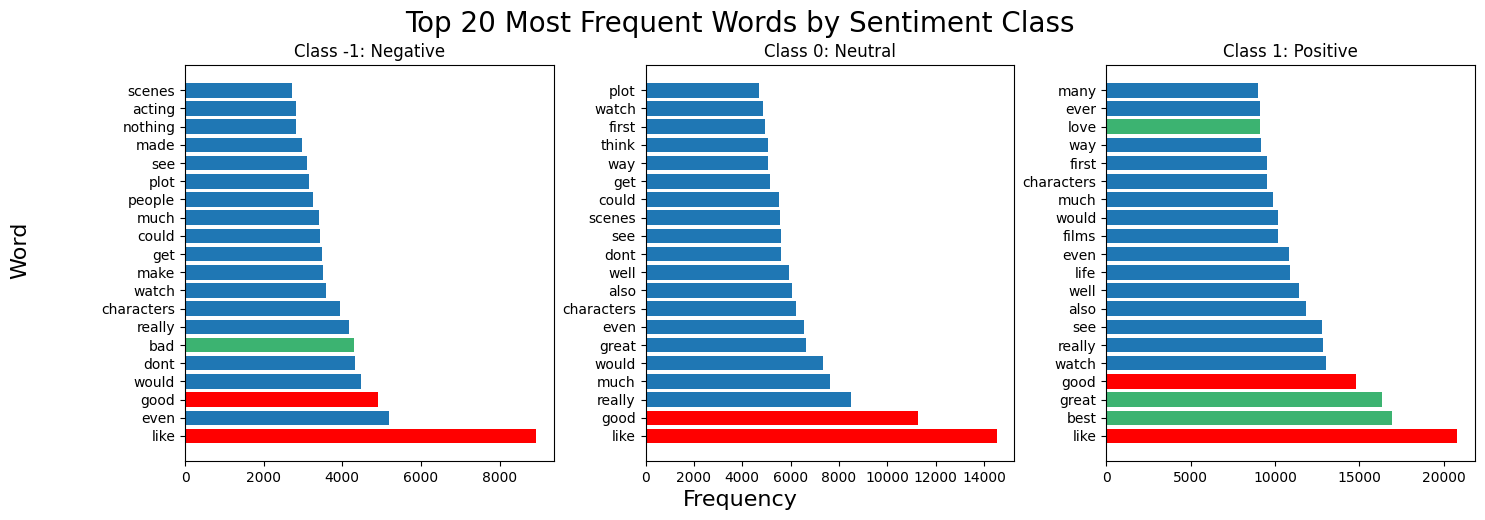

In [ ]:
# Bar plot of top 20 most frequent words by class
fig,axs = plt.subplots(1,3,figsize = (15,5))

bars1 = axs[0].barh(class1_freq_df['word'], class1_freq_df['frequency'])
axs[0].set_title('Class -1: Negative')
axs[0].set_facecolor('white')

bars2 = axs[1].barh(class2_freq_df['word'], class2_freq_df['frequency'])
axs[1].set_title('Class 0: Neutral')
axs[1].set_facecolor('white')

bars3 = axs[2].barh(class3_freq_df['word'], class3_freq_df['frequency'])
axs[2].set_title('Class 1: Positive')
axs[2].set_facecolor('white')

bars1[0].set_facecolor('red') # like
bars1[5].set_facecolor('mediumseagreen') # bad
bars1[2].set_facecolor('red') # good
bars2[0].set_facecolor('red') # like
bars2[1].set_facecolor('red') # good
bars3[0].set_facecolor('red') # like
bars3[1].set_facecolor('mediumseagreen') # best
bars3[2].set_facecolor('mediumseagreen') # great
bars3[3].set_facecolor('red') # good
bars3[17].set_facecolor('mediumseagreen') # love

fig.text(0.5, 0, 'Frequency', ha='center', va='center', fontsize=16)
fig.text(0.02, 0.5, 'Word', ha='center', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top = 0.87,left=0.13)
fig.suptitle('Top 20 Most Frequent Words by Sentiment Class', fontsize=20)

plt.show()

The bars in red represent a flaw that we observed across the sentiment classes. All 3 classes have the word "like" and "good" as one of the top few words, consistent with the word cloud previously. While "like" can convey a positive sentiment, it is also considered an informal word that individuals tend to use. For the word "good", it intuitively infers a positive sentiment but since it is present in all sentiment classes, this can prove to be a challenge for the models. Thus, the model accuracy will be affected since it is not a distinctive word that is unique to any class.

While there are limitations like these, the bars in green represent the more intuitive classification of words. For example, the 6th most frequent word used in the 'Negative' sentiment class is "bad", while the 2nd and 3rd most commonly used words in the 'Positive' sentiment class are "best" and "great".

However, it is difficult to discern a Neutral sentiment from a Positive/Negative one since there exists few words that convey a neutral sentiment. Moreover, the 6th most frequent word is "great" yet again.

These reflect considerations that must be taken into account when training and evaluating the models.

## Data analysis with Machine Learning

### Split into train and test --> oversample --> tfidf

We will be using `final_clean_reviews` as our input variable, and `label` as our target variable. 80% of the dataset will be used for model training, while 20% is allocated to testing. We utilised stratified sampling to ensure that the distribution of the training and test set remains consistent with the full dataset distribution.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

y = clean_df['label']
X = clean_df['final_clean_reviews']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [ ]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (49642,)
X_test shape:  (12411,)
y_train shape:  (49642,)
y_test shape:  (12411,)


### Distribution of Test Data

Counts for each class:
label
-1    2137
 0    3099
 1    7175
Name: count, dtype: int64


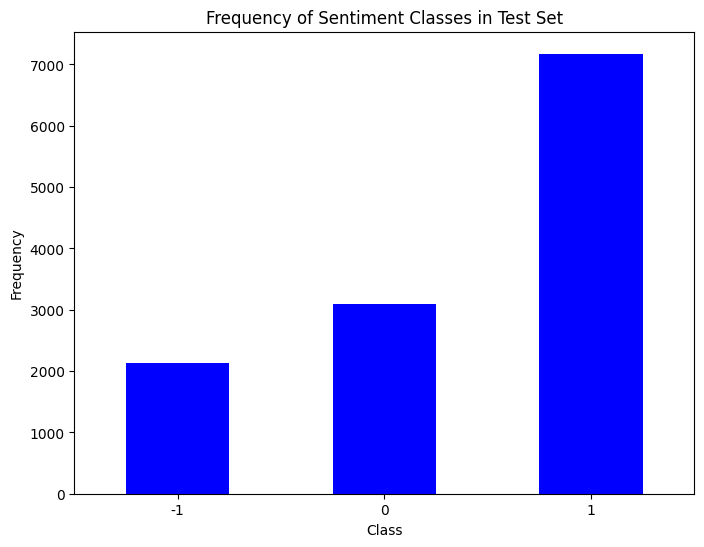

In [ ]:
frequency = pd.Series(y_test).value_counts()
desired_order = [-1, 0, 1]
frequency_ordered = frequency.reindex(desired_order)
print("Counts for each class:")
print(frequency_ordered)

plt.figure(figsize=(8, 6))
frequency_ordered.plot(kind='bar', color = 'blue')
plt.title('Frequency of Sentiment Classes in Test Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

The test data remains left-skewed even after stratified sampling, similar to the original `X_test`. Given a multiclass classification problem, stratification might not perfectly balance all classes, since the "Negative" and "Neutral" classes are significantly smaller than the "Positive" class. This serves to provide insights into model performance in real-world scenarios where class distributions are imbalanced.

### Evaluation Metrics and Fine Tuning

For our project, we will utilise the common evaluation metrics: accuracy, precision, recall and F1 score. 

For fine tuning purposes, we will be using Randomised Cross-Validation, robust to overfitting while being more efficient with high dimensional tf-idf data (Bergstra & Bengio, 2012). We went with this over grid search due to its reduced computational cost. Considering our data, this would save a considerable amount of time.

Given the imbalanced nature of our dataset, accuracy itself can easily be misleading as it alone does not account for the class distribution. Instead, we will be utilising *micro-averaged*  f1 score due to its ability to handle all classes fairly irrespective of their size (Kumar, 2023). This provides a balanced measure between precision and recall to evaluate our model performances before and after fine tuning.

### Standardised Pipeline

Our training data will be put through this pipeline for all the machine learning models: 

1. CountVectorizer: Converts text into a matrix of word counts.
2. TfidfTransformer: Scales down common words and boosts uncommon ones using TF-IDF.
3. RandomOverSampler: Balances class distribution by oversampling minority classes.
4. Model of choice

In [ ]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 29.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Naive Bayes

Next, we used Naive Bayes model. We used it as it is a simple and efficient model which works well with high dimensional tf-idf data. However, we understand that Naive Bayes model assumes things like feature independence (Nayak, 2023), and it is unable to consider context or sequence of words to classify sentiment. We will use this as a baseline to compare with our other models.

In [ ]:
textclassifier=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('nb', MultinomialNB())
])

textclassifier.fit(X_train, y_train)

y_pred = textclassifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

F1 Score: 0.732817661751672
Classification Report:
              precision    recall  f1-score   support

          -1       0.59      0.74      0.66      2137
           0       0.53      0.65      0.58      3099
           1       0.93      0.77      0.84      7175

    accuracy                           0.73     12411
   macro avg       0.68      0.72      0.69     12411
weighted avg       0.77      0.73      0.74     12411



### Fine-Tuned Naive Bayes

`vect__max_df`: To test the model performance when we ignore terms that appear in more than a certain percentage of the documents and when we don’t ignore any terms.

`vect__ngram_range`: (1, 1): only unigrams, (1, 2): unigrams and bigrams. Including bigrams can potentially capture more contextual information.

`tfidf__use_idf`: Whether to use idf (inverse document frequency) reweighting.

`nb__alpha`: To see how much smoothing might benefit the model’s predictions.


In [ ]:
textclassifier=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('nb', MultinomialNB())
])

param_dist = {
    'vect__max_df': [0.75, 1.0],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True, False],
    'nb__alpha':  [0.1, 1]
}

random_search = RandomizedSearchCV(textclassifier, param_dist, cv=5, scoring='f1_micro',verbose=1)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.75, 'tfidf__use_idf': True, 'nb__alpha': 0.1}
Best cross-validation score: 0.75


F1 Score: 0.7594069776810893
Fine-tuned NB Classification Report:
              precision    recall  f1-score   support

          -1       0.68      0.64      0.66      2137
           0       0.55      0.69      0.61      3099
           1       0.91      0.82      0.87      7175

    accuracy                           0.76     12411
   macro avg       0.71      0.72      0.71     12411
weighted avg       0.78      0.76      0.77     12411



Text(50.722222222222214, 0.5, 'Truth')

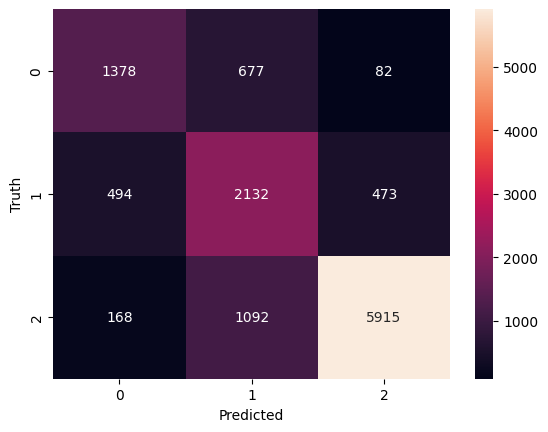

In [ ]:
from matplotlib import pyplot as plt

y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Print the classification report
print("Fine-tuned NB Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')	

Naive Bayes stands at 76% f1 score from 73% after fine tuning.

### Linear SVM

Next, we used the linear SVM model. It is a powerful tool when working with tf-idf data. It also generalises well on unseen data and is robust to overfitting through margin maximisation. We understand that it is sensitve to imbalanced data, and we have addressed the issue with our data preprocessing step. 

In [ ]:
textclassifier=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('svm', LinearSVC(max_iter = 10000))
])

textclassifier.fit(X_train, y_train)

y_pred = textclassifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
F1 Score: 0.7550559987108211
Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.69      0.66      2137
           0       0.56      0.57      0.56      3099
           1       0.89      0.85      0.87      7175

    accuracy                           0.76     12411
   macro avg       0.69      0.71      0.70     12411
weighted avg       0.76      0.76      0.76     12411



### Fine-Tuned Linear SVM

`vect__max_df`: To test the model performance when we ignore terms that appear in more than a certain percentage of the documents and when we don’t ignore any terms.

`vect__ngram_range`: (1, 1): only unigrams, (1, 2): unigrams and bigrams. Including bigrams can potentially capture more contextual information.

`tfidf__use_idf`: Whether to use idf (inverse document frequency) reweighting.

`svm__C`: To see how much regularization might benefit the model’s predictions.

In [ ]:
textclassifier=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('svm', LinearSVC(max_iter = 10000))
])

param_dist = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_df': [0.95, 1.0],
    'tfidf__use_idf': [True],
    'svm__C': [0.1, 1, 10]
}

random_search = RandomizedSearchCV(textclassifier, param_dist, cv=5, scoring='f1_micro', verbose=1)
random_search.fit(X_train, y_train)

# Output the best parameters and the best score achieved
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` 

F1 Score: 0.7979211989364273
Fine-tuned Linear SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.70      0.71      2137
           0       0.63      0.62      0.63      3099
           1       0.89      0.90      0.90      7175

    accuracy                           0.80     12411
   macro avg       0.75      0.74      0.74     12411
weighted avg       0.80      0.80      0.80     12411



Text(50.722222222222214, 0.5, 'Truth')

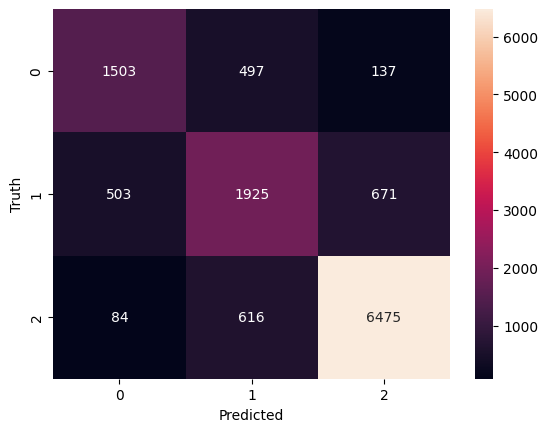

In [ ]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Print the classification report
print("Fine-tuned Linear SVM Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')	

Through our management of its limitations, we can see a higher f1 score of 80% after fine tuning for Linear SVM as compared to Naive Bayes.

### Logistic Regression

We used logistic regression as it is less prone to overfitting and more importantly, it tends to perform well when there are a smaller number of features as compared to number of observations, hence applicable to our dataset. However, we understand that it does assume a linear relationship between the data, and hence might be unable to capture a more complex interaction.

In [ ]:
textclassifier=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('lr', LogisticRegression(max_iter = 10000))
])

textclassifier.fit(X_train, y_train)

y_pred = textclassifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

F1 Score: 0.7762468777697205
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.73      0.70      2137
           0       0.59      0.63      0.61      3099
           1       0.91      0.85      0.88      7175

    accuracy                           0.78     12411
   macro avg       0.72      0.74      0.73     12411
weighted avg       0.79      0.78      0.78     12411



### Fine-Tuned Logistic Regression

`vect__max_df`: To test the model performance when we ignore terms that appear in more than a certain percentage of the documents and when we don’t ignore any terms.

`vect__ngram_range`: (1, 1): only unigrams, (1, 2): unigrams and bigrams. Including bigrams can potentially capture more contextual information.

`tfidf__use_idf`: Whether to use idf (inverse document frequency) reweighting.

`lr__C`: To see how much regularization might benefit the model’s predictions.

In [ ]:
textclassifier=Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('lr', LogisticRegression(max_iter = 10000))
])

param_dist = {
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': [True],
    'lr__C': [0.1, 1]
}

random_search = RandomizedSearchCV(textclassifier, param_dist, cv=5, scoring='f1_micro', verbose=1)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
/shared-libs/python3.11/py/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Best parameters: {'vect__ngram_range': (1, 2), 'vect__max_df': 0.75, 'tfidf__use_idf': True, 'lr__C': 1}
Best cross-validation score: 0.78


F1 Score: 0.7925227620659093
Fine-tuned LR Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.73      0.72      2137
           0       0.61      0.66      0.64      3099
           1       0.91      0.87      0.89      7175

    accuracy                           0.79     12411
   macro avg       0.74      0.75      0.75     12411
weighted avg       0.80      0.79      0.80     12411



Text(50.722222222222214, 0.5, 'Truth')

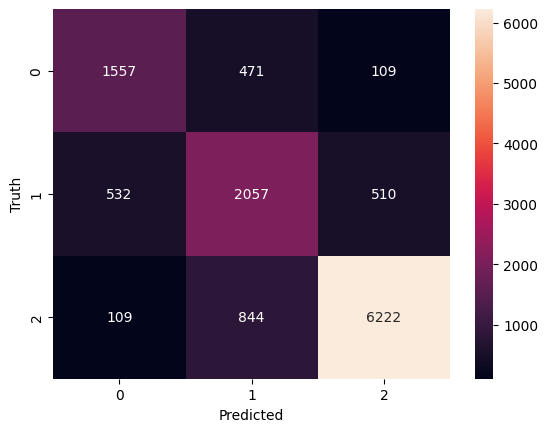

In [ ]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Print the classification report
print("Fine-tuned LR Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')	

We were able to improve the F1-score from 77% to 79% thanks to fine tuning.

### Random Forest

Random forest is another popular choice for multiclass sentiment analysis due to several reasons:
- **Ensemble Learning**: Random Forest combines multiple decision trees for improved performance. (Sruthi, 2021)
- **Feature Importance**: Provides a measure of feature importance aiding in feature selection and interpretation.
- **Handles Nonlinearity and Interactions**: Captures complex relationships and interactions between features.
- **Robust to Overfitting**: Less prone to overfitting compared to individual decision trees.
- **Scalability**: Efficiently handles large datasets with numerous features. 

An accuracy of 0.75 is achieved by the default version of the model.

In [ ]:
textclassifier = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('rf', RandomForestClassifier(random_state=42))  # Using RandomForestClassifier
])

textclassifier.fit(X_train, y_train)

y_pred = textclassifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average="micro")
print("F1 score:", f1)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
F1 score: 0.7506244460559182
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.59      0.64      2137
           0       0.59      0.48      0.53      3099
           1       0.81      0.92      0.86      7175

    accuracy                           0.75     12411
   macro avg       0.70      0.66      0.68     12411
weighted avg       0.74      0.75      0.74     12411



### Fine-Tuned Random Forest

In an attempt to improve the performance of Random Forest, we will utilise random search to identify the best set of parameters for our model. 

We will modify this set of parameters:
`tfidf__use_idf`: Whether to use idf (inverse document frequency) reweighting.
`rf__n_estimators`: The number of trees in the forest.
`rf__max_depth`: The maximum depth of the trees.
`rf__min_samples_split`: The minimum number of samples required to split an internal node.
`rf__min_samples_leaf`: The minimum number of samples required to be at a leaf node.


In [ ]:
text_classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('over', RandomOverSampler(random_state=777)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'tfidf__use_idf': [True],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
}

random_search = RandomizedSearchCV(text_classifier, param_dist, n_iter=10, cv=5, scoring='f1_micro', verbose=1, random_state=42)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'tfidf__use_idf': True, 'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_depth': None}
Best cross-validation score: 0.75


F1 Score: 0.7661751671903956
Fine-tuned RF Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.62      0.66      2137
           0       0.61      0.52      0.56      3099
           1       0.83      0.92      0.87      7175

    accuracy                           0.77     12411
   macro avg       0.72      0.68      0.70     12411
weighted avg       0.76      0.77      0.76     12411



Text(50.722222222222214, 0.5, 'Truth')

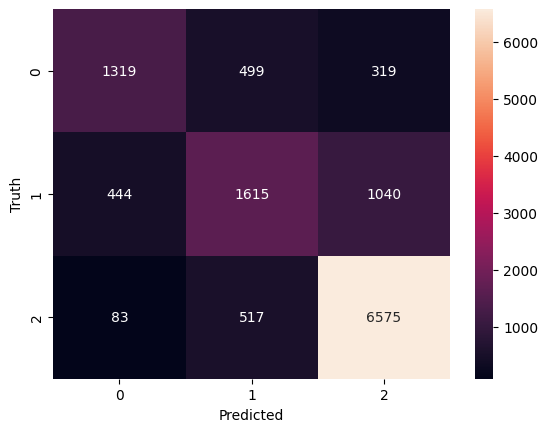

In [ ]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 Score:", f1)

# Print the classification report
print("Fine-tuned RF Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')	

## Proposed Solution: CNN-BiLSTM Model

For this project, we have chosen to implement CNN-BiLSTM (Long Short Term Memory). 

CNNs excel at capturing local patterns and spatial hierarchies within data. BiLSTMs process sequences in both forward and backward directins, allowing them to capture context from both past and future words. This bidrectional nature is known to help in understanding nuanced contextual information. Since using CNNs for sentiment analysis is less common despite its advantages, we decided to explore CNN which has also been known to be suitable for multiclass text classification. 

In [ ]:
!pip install keras
import warnings
import itertools
from numpy import array
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Bidirectional, Activation, Dropout, Dense, Flatten, LSTM, Embedding, BatchNormalization, Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

!pip install scikeras
from scikeras.wrappers import KerasClassifier
from math import floor
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
2024-04-27 08:59:39.763768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 08:59:39.812623: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 08:59:39.812657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 08:59:39.812688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 08:59:39.820680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, G

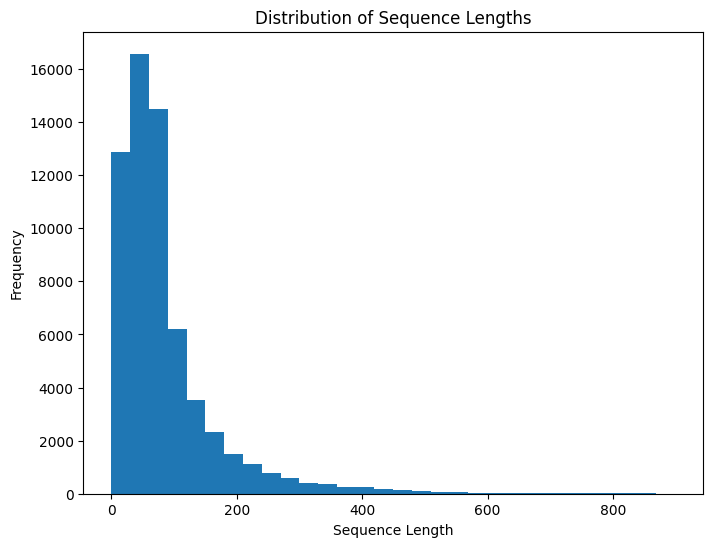

In [ ]:
# To determine max length, a value that covers the majority of sequences while minimising padding
sequence_lengths = [len(seq) for seq in clean_df['final_tokens']] # length of reviews

# Plot histogram of sequence lengths
plt.figure(figsize = (8,6))
plt.hist(sequence_lengths, bins = 30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')

plt.show()

From the above distribution, it is evident that most of the reviews have a sequence length of approximately 80. The longest review however, can be up to 850 words, though the frequency is very low.

For the maximum sequence length input in the deep learning models, we chose a value that covers 95% of sequences. This percentile is chosen because we want to ensure that most patterns are captured while minimising the chance of overfitting by the model.

In [ ]:
percentile = 95
maxlen = int(np.percentile(sequence_lengths, percentile)) 
print("MAX SEQUENCE LENGTH: ", maxlen)

MAX SEQUENCE LENGTH:  252


### Tokenisation and Padding

To convert raw text into a numerical format that is suitable for sentiment analysis, we utilised the `fit_on_texts()` and `texts_to_sequences()` functions. In addition, all input sequences need to have the same standardised length in order for the model to run, ensuring uniformity.

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(clean_df['final_clean_reviews'])
word_index = tokenizer.word_index
print('Number of unique words/tokens: ' , len(word_index)) # number of unique words

# Convert text data into a numerical format for further processing or modeling
X = tokenizer.texts_to_sequences(clean_df['final_clean_reviews'])
X_padded = pad_sequences(X, maxlen = maxlen, padding='post', truncating='post') # X_padded is np array

Y = clean_df['label']
Y_dummies = pd.get_dummies(clean_df['label'])

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print("VOCAB SIZE: ", vocab_size)

Number of unique words/tokens:  37217
VOCAB SIZE:  37218


### GloVe Embeddings

GloVe embeddings provide vector representations for words based on their semantic meaning which may help the neural network understand the semantics of words in the movie reviews. We incorporated these 200-dimension pre-trained embeddings in the initialisation of the model, which allows for faster convergence during training since the model starts with embeddings that are already close to the optimal representations. 


The `get_coefs()` function takes in a word and an array of float values as input, and returns the word and its corresponding embedding vector with a specified data type of float32.

The `get_embeddings_matrix()` function returns the embedding matrix and a list of words not found in the pre-trained embeddings. It also outputs the shape of the full embedding matrix and the percentage of words found in the pre-trained embeddings.

In [ ]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def get_embeddings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = list(embeddings_index.values())
    embed_dims = len(all_embs[0])
    print('Shape of Full Embedding Matrix:', len(all_embs), 'x', embed_dims)
    emb_mean,emb_std = np.mean(all_embs), np.std(all_embs)

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))
    
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words: 
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())
            
        if embedding_vector is not None: 
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [ ]:
from tqdm import tqdm
def load_emb_matrix(word_index):
    embed_file_path = '/content/drive/My_Drive/glove.6B.200d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embeddings_matrix(embeddings_index, word_index)

print('Loading Glove Model...')

emb_matrix, words_not_found = load_emb_matrix(tokenizer.word_index)

Loading Glove Model...
400000it [00:29, 13493.12it/s]
Built Embedding Index: 400000
Shape of Full Embedding Matrix: 400000 x 200
100%|██████████| 37217/37217 [00:00<00:00, 431471.30it/s]% of Vectors found in Corpus 0.8746003170594083



From our self-defined function and creation of the embedding matrix, **87%** of the unique words (37,218) have embeddings provided by GloVe. This is desirable as there are fewer out-of-vocabulary words which can pose challenges during training. It also allows for a significant portion of the embedding matrix to be initialised with meaningful pre-trained values.

### Split into Train and Test

Similarly, we have also divided the data into 80% training and 20% testing, coupled with stratified sampling.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_padded,Y_dummies, test_size = 0.2, random_state = 42, stratify = Y_dummies)

In [ ]:
positive_counts = 0
for entry in Y_test.iloc[:,2]:
    if entry == True:
        positive_counts += 1
print("Positive instances:", positive_counts)

negative_counts = 0
for entry in Y_test.iloc[:,0]:
    if entry == True:
        negative_counts += 1
print("Negative instances:", negative_counts)

neutral_counts = 0
for entry in Y_test.iloc[:,1]:
    if entry == True:
        neutral_counts += 1
print("Neutral instnaces:", neutral_counts)

Positive instances: 7175
Negative instances: 2137
Neutral instnaces: 3099


We further split the training set into 2 subsets:
- Training set: 80%
- Validation set: 20%

The resulting dimensions are displayed below.

In [ ]:
# Split train set further into train and validation sets (80% train, 20% validation)
X_train_cnn, X_val, Y_train_cnn, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print('Training dimensions:', X_train_cnn.shape, Y_train_cnn.shape)
print('Validation dimensions:', X_val.shape, Y_val.shape)
print('Testing dimensions:', X_test.shape, Y_test.shape)

Training dimensions: (39713, 252) (39713, 3)
Validation dimensions: (9929, 252) (9929, 3)
Testing dimensions: (12411, 252) (12411, 3)


To ensure that our input features are put into the model as the right data type, we converted all our data to numpy arrays. 

In [ ]:
# Convert training data to NumPy array
Xtrain_array = np.array(X_train_cnn)

# Check the shape of the resulting array
print("training:", Xtrain_array.shape)

# Convert training label data to NumPy array
Ytrain_array = np.array(Y_train_cnn)
# Check the shape of the resulting array
print("training label:", Ytrain_array.shape)

# Convert validation data to NumPy array
Xval_array = np.array(X_val)

# Check the shape of the resulting array
print("validation:", Xval_array.shape)

# Convert test data to NumPy array
Xtest_array = np.array(X_test)

# Check the shape of the resulting array
print("testing:", Xtest_array.shape)


training: (39713, 252)
training label: (39713, 3)
validation: (9929, 252)
testing: (12411, 252)


### Countering Imbalanced Data with Oversampling

Our group decided to proceed with oversampling with `RandomOverSampler`, as `SMOTE()` is not usually used for categorical outputs.

Machine learning models tend to be biased towards predicting the majority class, especially in our case where the discrepancy is quite significant. This bias can lead to poor performance on minority classes, as the model may not learn to distinguish them effecitvely. In addition, the loss function we are using `(categorical_crossentropy)` becomes dominated by the majority class (ie. "Positive").

We also acknowledge that oversampling can exacerbate overfitting when synthetic samples introduce noise into the training data.

To balance the tradeoff, we will be using evaluation metrics that are robut to imbalanced classes elaborated further below.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 25.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


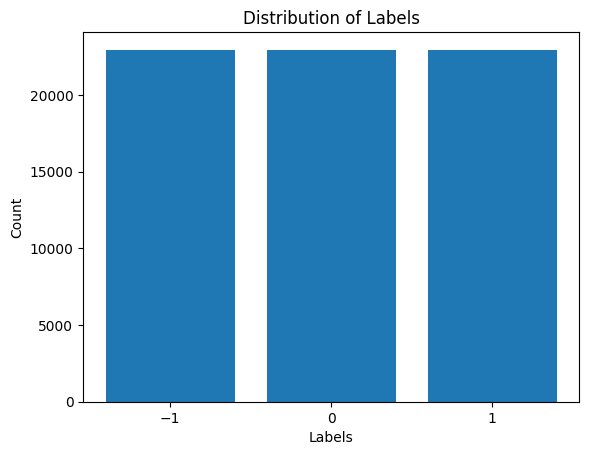

In [ ]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=777)
X_oversampled, y_oversampled = ros.fit_resample(Xtrain_array, Ytrain_array)

label_counts = np.sum(y_oversampled, axis=0)

# Plotting the distribution
labels = [-1, 0, 1]  # Update with your actual labels
plt.bar(labels, label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(labels)
plt.show()

## Model Architecture (how to title this heading) 

We have included 2 variations of the CNN-BiLSTM model with different hyperparameters. The values of each hyperparameter are randomly chosen, and we have adjusted them numerous times. The variations included in this notebook output the highest accuracies on the test set.

- In both variations, we used the `relu` activation function in the intermediate layers as it introduces non-linearity to the model, allowing it to learn complex mappings between input and output.
- For the last `Dense()` layer, we utilised the `softmax` activation function since we are conducting multiclass classification.

The first variation consisted of a 1-dimensional convolutional layer and a Bidirectional LSTM layer. 



*Note: There is a typo in the training-validation curves below. The orange line in the graphs represents the **validation** set, not the test set.*

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.layers import BatchNormalization

# Define learning rate schedule function
def lr_schedule(epoch, lr):
  if epoch < 7:
    return lr
  else:
    return lr * 0.95

lr_scheduler = LearningRateScheduler(lr_schedule)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

batch_size = 32
epochs = 20
embedding_dim = 200
max_length = maxlen 

model2 = Sequential()
model2.add(Embedding(vocab_size, output_dim=embedding_dim, weights = [emb_matrix],input_length=max_length))
model2.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.32))  # Increased dropout rate
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.4))  # Increased dropout rate
model2.add(BatchNormalization())  # Batch Normalization layer
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.002), metrics=['accuracy'])
model2.summary()

history = model2.fit(X_oversampled, y_oversampled, validation_data=(Xval_array, Y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stopping, lr_scheduler])


2287/2287 - 1660s - loss: 0.1242 - accuracy: 0.9645 - val_loss: 1.2196 - val_accuracy: 0.7338 - lr: 4.5125e-04 - 1660s/epoch - 726ms/step


291/291 [==============================] - 47s 161ms/step - loss: 0.6378 - accuracy: 0.7744
Test Score:  0.6378142833709717
Test Accuracy:  0.7743875980377197


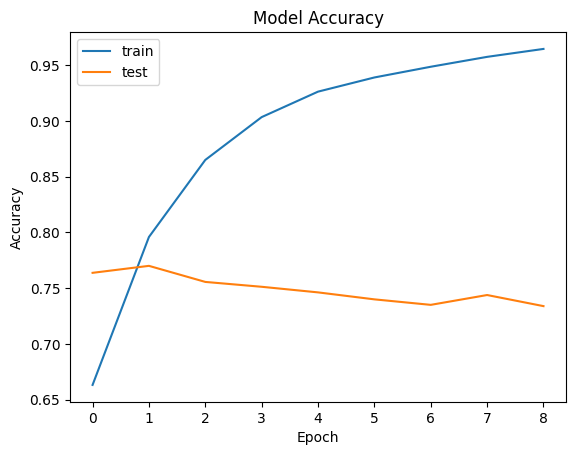

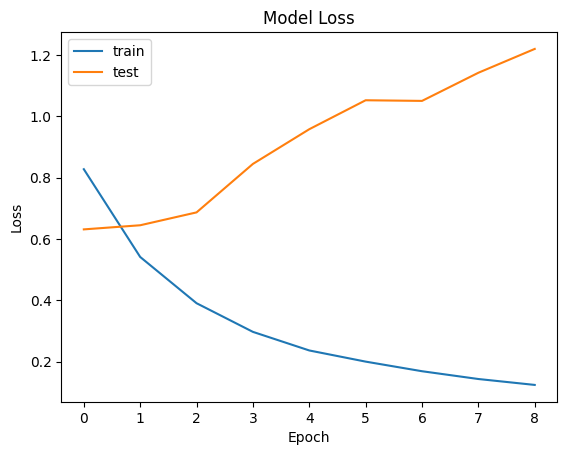

In [ ]:
score = model2.evaluate(X_test, Y_test, verbose = 1)
print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = "upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = "upper left")
plt.show()


As the number of epochs increased, the validation accuracy decreased while the validation loss increased. The validation loss seems to increase more relative to the decrease in the validation accuracy. On the other hand, the training accuracy is steadily increasing, and the training loss is gradually decreasing. 

Comparing both training and testing sets, this model is overfitting as it learns to fit the training data better, but not generalising well to unseen data. In other words, the model is learning to memorise the training data, capturing noise that do not exist in the validation set.

As such, we decided to utilise the L2 regularisation within the `Dense()` layer to address the overfitting. However, we also wanted to increase the validation accuracy at the same time, hence adding another `Conv1D()` layer, accompanied with `MaxPooling1D()` and the `Dropout()` layer. This variation is shown below.

In [ ]:
# non-stemmed, filtered frequency
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.layers import BatchNormalization

# Define learning rate schedule function
def lr_schedule(epoch, lr):
  if epoch < 7:
    return lr
  else:
    return lr * 0.95

lr_scheduler = LearningRateScheduler(lr_schedule)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

batch_size = 32
epochs = 10
embedding_dim = 200
max_length = maxlen # can change

model2 = Sequential()
model2.add(Embedding(vocab_size, output_dim=embedding_dim, weights = [emb_matrix],input_length=max_length))
model2.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.6))  # Increased dropout rate
model2.add(Conv1D(64, 3, activation = 'relu', padding = 'same'))
model2.add(MaxPooling1D(2))
model2.add(Dropout(0.4))
model2.add(Bidirectional(LSTM(128)))
model2.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.001)))
model2.add(Dropout(0.4))  # Increased dropout rate
model2.add(BatchNormalization())  # Batch Normalization layer
model2.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.001)))

model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model2.summary()

history = model2.fit(X_oversampled, y_oversampled, validation_data=(Xval_array, Y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[early_stopping, lr_scheduler])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 252, 200)          7443600   
                                                                 
 conv1d (Conv1D)             (None, 252, 128)          76928     
                                                                 
 max_pooling1d (MaxPooling1  (None, 126, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 126, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 63, 64)            0         
 g1D)                                                   

In [ ]:
score = model2.evaluate(X_test, Y_test)

388/388 [==============================] - 43s 111ms/step - loss: 0.5811 - accuracy: 0.7750


Test Score:  0.5810747742652893
Test Accuracy:  0.7750383019447327


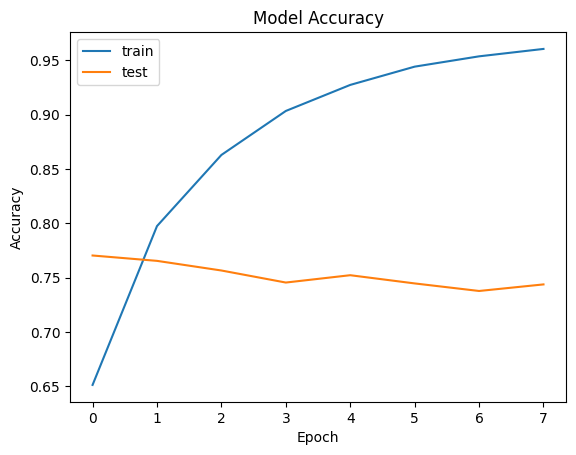

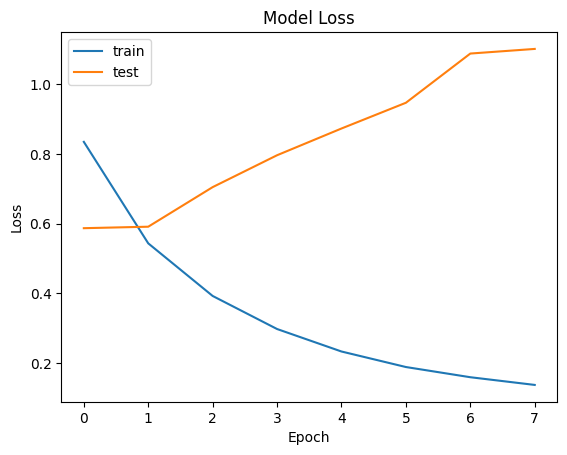

In [ ]:
print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = "upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = "upper left")
plt.show()

From the above graphs, the validation loss is still increasing, but the validation accuracies across the epochs is slightly better. When we used the model to predict the test set, this model resulted in a slightly higher accuracy of 0.001. Even though we added an additional convolutional layer, the validation loss looked similar to the previous variation. This suggests that it's probably not this layer that is causing the increasing trend in the loss.

The L2 regularisation technique did not prove to help much as well. However, we tested the model with multiple `Dropout()` rates and `BatchNormalization()`, but the overfitting problem remains. 

We have explored possible reasons for this situation in the *Evaluation* section below.

However, accuracy can be misleading as an evaluation metric for the imbalanced test set, so we will be focusing on the micro-average F1 score instead.

388/388 [==============================] - 40s 104ms/step


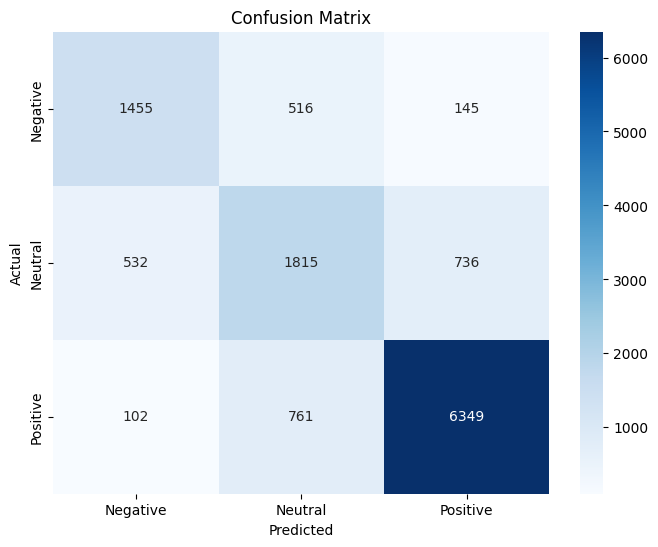

In [ ]:
import seaborn as sns
# 1. Get Predictions
y_pred = model2.predict(X_test)

# 2. Convert Predictions to Class Labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)  # Assuming Y_test is one-hot encoded

# 3. Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Based on the confusion matrix, we manually calculated the F1-score since we will be using that as our evaluation metric. With both the precision and recall values standing at **0.78**, the F1-score is calculated to be **0.78** using micro-average as well.

One reason why the metric value is lower than expected is due to the intrinsic limitation of the data. Deep learning requires high quality data. As stated previously, words such as "like" and "good" are listed as one of the most frequently used words in all the sentiment classes. Even in the "Negative" class that consists of reviews rated from 1 to 3 stars, "good" still remains one of the top words, which is counterintuitive. This is a limitation of the data that we are unable to control.

Even though deep learning models are known to be able to capture the semantics, due to this limitation, they can still be misled by misleading data like this.

Another reason could be that the data is originally unlabelled since we scraped them from the IMDb website. While we can simply classify them into "Positive" and "Negative" classes like what most would have done, our objective is to make it a more reliable experience for users hence the decision to include a "Neutral" category.

Given the ambiguity in language in neutral sentiments and subtle expressions, it is challenging to discern neutral sentiments from positive and/or negative ones. Neutral sentiments may not contain explicit emotional keywords such as "great" or "bad", making them less identifiable by deep learning algorithms. Hence, there is a tradeoff between our aim and the nature of the reviews.

## Evaluation: Deep Learning VS Machine learning Models

Although micro-average F1 score will be our focus, we will also consider macro-average evaluation metrics to offer a different perspective, since micro-average accuracy, precision and recall give the same values for multiclass classification.

| Model | Micro-average F1 |
|-----------------|-----------------|
| CNN-BiLSTM      | 0.78   | 
| Linear SVM      | 0.80    | 
| Logistic Regression   | 0.79    | 
| Random Forest   | 0.77    | 
| Naive Bayes     | 0.76    | 


**Macro-average metrics:**
| Model                 | Precision | Recall | F1 Score |
|-----------------------|------------------|-----------------|-----------------|
| CNN-BiLSTM            | 0.73             | 0.73    | 0.73    |
| Linear SVM            | 0.75             | 0.74   | 0.74    |
| Logistic Regression   | 0.74             | 0.74    | 0.75    |
| Random Forest         | 0.72             | 0.68    | 0.70    |
| Naive Bayes           | 0.71             | 0.72   | 0.71    |


*Note: The values here represent the performance of the models after fine-tuning.*

Based on the micro-average F1 score, linear SVM achieved the highest performance of 0.80, followed by logistic regression at 0.79. 

Despite the lower complexity of the two linear models, they outperformed the deep-learning model, CNN-BiLSTM. Several factors could have played a part in this outcome: 

**1. Oversampling for sentiment analysis**
Deep-learning models usually require extensive data, especially for sentiment analysis with numerous features. Our training dataset has approximately only 72,000 training points, but nearly 50% are generated from oversampling in an attempt to stabilize training of the model and promote better generalization. The vast number of synthetic samples can introduce noise into the training data and result in overfitting as we observed from the training-validation curve of CNN-BiLSTM. This is despite our attempts to reduce overfitting by incorporating regularization techniques.  

**2. Sensitivity of CNN-BiLSTM to imbalanced classes in the test set**
Our model is trained on movie reviews with a balanced distribution, which may not generalise well to real-world scenarios with varying distributions. For example, the CNN-BiLSTM model displayed near-perfect accuracy on the training data, but validation accuracy stagnated at approximately 0.75 and decreased as the number of epochs increased. This suggests that our model struggles to generalise to real-world scenarios and might fail to learn robust features that are applicable to imbalanced data.

**3. Limitations of BiLSTMS** 
BiLSTMS do not perform optimally if the data has very long-range dependencies. They are also prone to vanishing gradient issues (Safwan Mahmood Al-Selwi et al., 2023). This could result in the model being ineffective in understanding the context of the review, leading to poorer sentiment analysis.

Despite these limitations of the deep-learning model, Naive Bayes and Random Forest performed the worst, with micro-average F1 scores of 0.76 and 0.77 respectively. 

**4. Limitations of CNN**
In CNNs, the position and orientation of words within the text are ont explicitly encoded. CNNs process text as a fixed-size window or kernel moving across the test, capturing local patterns without considering the sequential nature of language. Hence, they may not excel in tasks requiring a deep understanding of context or grammatical structure. Since the CNN layer comes before the LSTM layer in our model, the input for the LSTM layer could have been compromised, causing the lower F1-score.

For Naive Bayes, the **assumption of feature (word) independence** is a fundamental aspect of its modelling approach (Nayak, 2023). However, this assumption may not hold true where the sentiment expressed relies heavily on the interaction between different word features, for instance "not happy" conveys a negative sentiment despite the presence of the positive sentiment-tagged word "happy". The inability of NB to adequately capture dependencies within the features might hence result in its weaker performance. 

For Random Forest, their ability to capture complex interactions and dependencies in imbalanced datasets may be constrained by the individual decision trees' limited scope. (Brownlee, 2020) Each tree is trained on subsets of features and samples. In imbalanced data like the test set, decision trees tend to be biased towards predicting the majority class as well.


#### Comparing micro- and macro-average metrics:
Macro-average scores are consistently lower than the micro-average scores. This suggests that the model is struggling with minority classes, such as negative and neutral sentiments. This could be due to the method of oversampling conducted. A consequence is that the models may be overlooking insights into audience preferences, potentially leading to suboptimal decision-making. 



## Future Development

For future development of our project, we propose the following enhancements: 

**Enhanced Attention Mechanisms:**
Building on the strengths of BiLSTMs, we can incorporate more sophisticated attention mechanisms to better capture long-range dependencies within the text. By refining attention mechanisms within the existing architecture, we aim to improve the model's ability to focus on relevant information across lengthy sequences.

**Starting with Bidirectional LSTM Layer:**
Initiating the deep learning model with the Bidirectional LSTM layer instead of the CNN layer. This strategic change aims to leverage the Bidirectional LSTM's capacity to capture contextual information effectively, potentially improving sentiment analysis performance.

**Utilization of Ensemble Methods:**
Leveraging ensemble methods to combine predictions from multiple models, thereby improving overall accuracy and robustness of sentiment analysis. This approach allows us to harness the diverse strengths of individual models and enhance the predictive power of the ensemble.

**Rebalancing Data Distribution:**
Exploring methods to rebalance data distribution, such as creating synthetic samples of minority classes using Adaptive Synthetic Sampling. However, it's crucial to be mindful of potential overfitting and increased computational cost and to carefully validate the model's performance on unseen data. Other methods, such as collecting more instances of the data, could also be considered, despite their time-intensive nature.

Contrary to popular beliefs, we did not achieve particularly high performance from our deep learning model. However, this project reveals that discerning neutral sentiments proves to be challenging due to its ambiguity and subtle nuances. In addition, understanding the risks of oversampling and quality of data is vital in deep learning model performance. The ability of linear models also cannot be underestimated, and proper hyperparameter tuning is required for optimal performance, though it is computationally expensive.

## References

Varghese, D., 2018. Comparative Study on Classic Machine learning Algorithms , Part-2. Medium. URL https://medium.com/@dannymvarghese/comparative-study-on-classic-machine-learning-algorithms-part-2-5ab58b683ec0 (accessed 4.28.24).

Bergstra, J., & Bengio, Y. (2012). Random search for hyper-parameter optimization. Journal of Machine Learning Research, 13(1), 281–305.

Brownlee, J. (2020). Bagging and Random Forest for Imbalanced Classification. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/.

Kumar, A. (2023, December 30). Micro-average, macro-average, weighting: precision, recall, F1-Score. Analytics Yogi. https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/#Conclusions

Nayak, V. (2023, May 22). Why Naive Bayes Algorithm makes assumptions of features independence. Medium. 
https://medium.com/@vishalnayak/why-naive-bayes-algorithm-makes-assumptions-of-features-independence-cc98292b9e28

Safwan Mahmood Al-Selwi, Mohd Fadzil Hassan, Said Jadid Abdulkadir and Amgad Muneer (2023). LSTM Inefficiency in Long-Term Dependencies Regression Problems. Journal of Advanced Research in Applied Sciences and Engineering Technology, 30(3), pp.16–31. doi:https://doi.org/10.37934/araset.30.3.1631.
‌
Sruthi, E.R. (2021). Random Forest | Introduction to Random Forest Algorithm. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/.

Islam, Md.S., Kabir, M.N., Ghani, N.A., Zamli, K.Z., Zulkifli, N.S.A., Rahman, Md.M., Moni, M.A., 2024. Challenges and future in deep learning for sentiment analysis: a comprehensive review and a proposed novel hybrid approach. Artif Intell Rev 57, 62. https://doi.org/10.1007/s10462-023-10651-9
‌

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ef70b91f-3cff-4f32-b062-9f3ea257deb4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>